# Install and import

In this study, we will use the WikiText2 dataset, therefore we need to install torchdata. We will analyze Transformers on this dataset, so we import useful packages to this end.

In [ ]:
#Install Dataset
!pip install torchdata

In [ ]:
#Clear cache
device = 'cuda'
import torch, gc
import os
gc.collect()
torch.cuda.empty_cache()

In [ ]:
#Imports
import time
import copy
from typing import Optional, Any, Union, Callable, Tuple, List
import numpy as np

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import MultiheadAttention
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn.init import xavier_uniform_
from  torch.nn import Dropout
from  torch.nn import Linear
from  torch.nn import LayerNorm
from torchtext.datasets import WikiText2, WikiText103
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import math
from torch.utils.data import dataset

# Model classes and helper methods

In this section we define the two main classes that we will use: BaselineTransformer and PlaceboTransformer. These two classes are similar with the exception that the PlaceboTransformer class allows to choose a Feed Forward substitution to the MultiHeadAttention for each encoder layer. The Transformer created with these two classes has a simple linear layer as decoder. Other useful classes and methods are also defined in this section.

In [ ]:
# Create Positional Encoding, Formula used in Attention is all you need
# Source Code: https://pytorch.org/docs/stable/_modules/torch/nn/modules/transformer.html#Transformer
# and https://pytorch.org/tutorials/beginner/transformer_tutorial.html

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

## The baseline Transformer class

In [ ]:
# Create the Transformer
class BaselineTransformer(Module):
    r"""A transformer model. User is able to modify the attributes as needed. The architecture
    is based on the paper "Attention Is All You Need". Ashish Vaswani, Noam Shazeer,
    Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N Gomez, Lukasz Kaiser, and
    Illia Polosukhin. 2017. Attention is all you need. In Advances in Neural Information
    Processing Systems, pages 6000-6010.

    Args:
        d_model: the number of expected features in the encoder/decoder inputs (default=512).
        nhead: the number of heads in the multiheadattention models (default=8).
        num_encoder_layers: the number of sub-encoder-layers in the encoder (default=6).
        num_decoder_layers: the number of sub-decoder-layers in the decoder (default=6).
        dim_feedforward: the dimension of the feedforward network model (default=2048).
        dropout: the dropout value (default=0.1).
        activation: the activation function of encoder/decoder intermediate layer, can be a string
            ("relu" or "gelu") or a unary callable. Default: relu
        custom_encoder: custom encoder (default=None).
        custom_decoder: custom decoder (default=None).
        layer_norm_eps: the eps value in layer normalization components (default=1e-5).
        batch_first: If ``True``, then the input and output tensors are provided
            as (batch, seq, feature). Default: ``False`` (seq, batch, feature).
        norm_first: if ``True``, encoder and decoder layers will perform LayerNorms before
            other attention and feedforward operations, otherwise after. Default: ``False`` (after).

    Examples::
        >>> transformer_model = nn.Transformer(nhead=16, num_encoder_layers=12)
        >>> src = torch.rand((10, 32, 512))
        >>> tgt = torch.rand((20, 32, 512))
        >>> out = transformer_model(src, tgt)

    Note: A full example to apply nn.Transformer module for the word language model is available in
    https://github.com/pytorch/examples/tree/master/word_language_model

    """

    def __init__(self, ntoken: int, d_model: int = 512, nhead: int = 8, dim_feedforward: int = 2048,
                 num_encoder_layers: int = 6, dropout: float = 0.1,
                 activation: Union[str, Callable[[Tensor], Tensor]] = F.gelu,
                 custom_encoder: Optional[Any] = None, custom_decoder: Optional[Any] = None,
                 layer_norm_eps: float = 1e-5, batch_first: bool = False, norm_first: bool = False,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(BaselineTransformer, self).__init__()

        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.emb_encoder = nn.Embedding(ntoken, d_model)

        encoder_layer = BaselineTransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout,
                                                    activation, layer_norm_eps, batch_first, norm_first,
                                                    **factory_kwargs)
        encoder_norm = LayerNorm(d_model, eps=layer_norm_eps, **factory_kwargs)
        self.transformer_encoder = BaselineTransformerEncoder(encoder_layer, num_encoder_layers, encoder_norm)


        self.decoder = nn.Linear(d_model, ntoken)


        self.d_model = d_model
        self.nhead = nhead

        self.batch_first = batch_first


    def forward(self, src: Tensor, src_mask: Optional[Tensor] = None) -> Tensor:
        r"""Take in and process masked source/target sequences.

        Args:
            src: the sequence to the encoder (required).
            src_mask: the additive mask for the src sequence (optional).


        Shape:
            - src: :math:`(S, E)` for unbatched input, :math:`(S, N, E)` if `batch_first=False` or
              `(N, S, E)` if `batch_first=True`.
            - tgt: :math:`(T, E)` for unbatched input, :math:`(T, N, E)` if `batch_first=False` or
              `(N, T, E)` if `batch_first=True`.
            - src_mask: :math:`(S, S)` or :math:`(N\cdot\text{num\_heads}, S, S)`.
            - tgt_mask: :math:`(T, T)` or :math:`(N\cdot\text{num\_heads}, T, T)`.
            - memory_mask: :math:`(T, S)`.
            - src_key_padding_mask: :math:`(S)` for unbatched input otherwise :math:`(N, S)`.
            - tgt_key_padding_mask: :math:`(T)` for unbatched input otherwise :math:`(N, T)`.
            - memory_key_padding_mask: :math:`(S)` for unbatched input otherwise :math:`(N, S)`.

            Note: [src/tgt/memory]_mask ensures that position i is allowed to attend the unmasked
            positions. If a ByteTensor is provided, the non-zero positions are not allowed to attend
            while the zero positions will be unchanged. If a BoolTensor is provided, positions with ``True``
            are not allowed to attend while ``False`` values will be unchanged. If a FloatTensor
            is provided, it will be added to the attention weight.
            [src/tgt/memory]_key_padding_mask provides specified elements in the key to be ignored by
            the attention. If a ByteTensor is provided, the non-zero positions will be ignored while the zero
            positions will be unchanged. If a BoolTensor is provided, the positions with the
            value of ``True`` will be ignored while the position with the value of ``False`` will be unchanged.

            output: :math:`(T, E)` for unbatched input, :math:`(T, N, E)` if `batch_first=False` or
              `(N, T, E)` if `batch_first=True`.

            Note: Due to the multi-head attention architecture in the transformer model,
            the output sequence length of a transformer is same as the input sequence
            (i.e. target) length of the decoder.

            where S is the source sequence length, T is the target sequence length, N is the
            batch size, E is the feature number

        Examples:
            >>> # xdoctest: +SKIP
            >>> output = transformer_model(src, tgt, src_mask=src_mask, tgt_mask=tgt_mask)
        """

        src = self.emb_encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)

        memory, attended_encoder_list = self.transformer_encoder(src, mask=src_mask)#, src_key_padding_mask=src_key_padding_mask)
        output = self.decoder(memory)
        return output, attended_encoder_list


    def _reset_parameters(self):
        r"""Initiate parameters in the transformer model."""

        for p in self.parameters():
            if p.dim() > 1:
                xavier_uniform_(p)


class BaselineTransformerEncoder(Module):
    r"""TransformerEncoder is a stack of N encoder layers. Users can build the
    BERT(https://arxiv.org/abs/1810.04805) model with corresponding parameters.

    Args:
        encoder_layer: an instance of the TransformerEncoderLayer() class (required).
        num_layers: the number of sub-encoder-layers in the encoder (required).
        norm: the layer normalization component (optional).
        enable_nested_tensor: if True, input will automatically convert to nested tensor
            (and convert back on output). This will improve the overall performance of
            TransformerEncoder when padding rate is high. Default: ``True`` (enabled).

    Examples::
        >>> encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
        >>> transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
        >>> src = torch.rand(10, 32, 512)
        >>> out = transformer_encoder(src)
    """
    __constants__ = ['norm']

    def __init__(self, encoder_layer, num_layers, norm=None, enable_nested_tensor=True, mask_check=True):
        super(BaselineTransformerEncoder, self).__init__()
        self.layers = _get_clones(encoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm
        self.enable_nested_tensor = enable_nested_tensor
        self.mask_check = mask_check


    def forward(self, src: Tensor, mask: Optional[Tensor] = None, src_key_padding_mask: Optional[Tensor] = None) -> Tensor:
        r"""Pass the input through the encoder layers in turn.

        Args:
            src: the sequence to the encoder (required).
            mask: the mask for the src sequence (optional).
            src_key_padding_mask: the mask for the src keys per batch (optional).

        Shape:
            see the docs in Transformer class.
        """
        attn_list = []
        output = src
        for mod in self.layers:
            output, attn = mod(output, src_mask=mask) #src_key_padding_mask=src_key_padding_mask_for_layers)
            attn_list.append(attn)


        if self.norm is not None:
            output = self.norm(output)

        return output, attn_list



class BaselineTransformerEncoderLayer(Module):
    r"""TransformerEncoderLayer is made up of self-attn and feedforward network.
    This standard encoder layer is based on the paper "Attention Is All You Need".
    Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N Gomez,
    Lukasz Kaiser, and Illia Polosukhin. 2017. Attention is all you need. In Advances in
    Neural Information Processing Systems, pages 6000-6010. Users may modify or implement
    in a different way during application.

    Args:
        d_model: the number of expected features in the input (required).
        nhead: the number of heads in the multiheadattention models (required).
        dim_feedforward: the dimension of the feedforward network model (default=2048).
        dropout: the dropout value (default=0.1).
        activation: the activation function of the intermediate layer, can be a string
            ("relu" or "gelu") or a unary callable. Default: relu
        layer_norm_eps: the eps value in layer normalization components (default=1e-5).
        batch_first: If ``True``, then the input and output tensors are provided
            as (batch, seq, feature). Default: ``False`` (seq, batch, feature).
        norm_first: if ``True``, layer norm is done prior to attention and feedforward
            operations, respectively. Otherwise it's done after. Default: ``False`` (after).

    Examples::
        >>> encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
        >>> src = torch.rand(10, 32, 512)
        >>> out = encoder_layer(src)

    Alternatively, when ``batch_first`` is ``True``:
        >>> encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8, batch_first=True)
        >>> src = torch.rand(32, 10, 512)
        >>> out = encoder_layer(src)

    Fast path:
        forward() will use a special optimized implementation if all of the following
        conditions are met:

        - Either autograd is disabled (using ``torch.inference_mode`` or ``torch.no_grad``) or no tensor
          argument ``requires_grad``
        - training is disabled (using ``.eval()``)
        - batch_first is ``True`` and the input is batched (i.e., ``src.dim() == 3``)
        - activation is one of: ``"relu"``, ``"gelu"``, ``torch.functional.relu``, or ``torch.functional.gelu``
        - at most one of ``src_mask`` and ``src_key_padding_mask`` is passed
        - if src is a `NestedTensor <https://pytorch.org/docs/stable/nested.html>`_, neither ``src_mask``
          nor ``src_key_padding_mask`` is passed
        - the two ``LayerNorm`` instances have a consistent ``eps`` value (this will naturally be the case
          unless the caller has manually modified one without modifying the other)

        If the optimized implementation is in use, a
        `NestedTensor <https://pytorch.org/docs/stable/nested.html>`_ can be
        passed for ``src`` to represent padding more efficiently than using a padding
        mask. In this case, a `NestedTensor <https://pytorch.org/docs/stable/nested.html>`_ will be
        returned, and an additional speedup proportional to the fraction of the input that
        is padding can be expected.
    """
    __constants__ = ['batch_first', 'norm_first']

    def __init__(self, d_model: int, nhead: int, dim_feedforward: int = 2048, dropout: float = 0.1,
                 activation: Union[str, Callable[[Tensor], Tensor]] = F.relu,
                 layer_norm_eps: float = 1e-5, batch_first: bool = False, norm_first: bool = False,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(BaselineTransformerEncoderLayer, self).__init__()
        self.self_attn = MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=batch_first,
                                            **factory_kwargs)
        # Implementation of Feedforward model
        self.linear1 = Linear(d_model, dim_feedforward, **factory_kwargs)
        self.dropout = Dropout(dropout)
        self.linear2 = Linear(dim_feedforward, d_model, **factory_kwargs)

        self.norm_first = norm_first
        self.norm1 = LayerNorm(d_model, eps=layer_norm_eps, **factory_kwargs)
        self.norm2 = LayerNorm(d_model, eps=layer_norm_eps, **factory_kwargs)
        self.dropout1 = Dropout(dropout)
        self.dropout2 = Dropout(dropout)

        self.activation = activation

    def __setstate__(self, state):
        super(BaselineTransformerEncoderLayer, self).__setstate__(state)
        if not hasattr(self, 'activation'):
            self.activation = F.relu



    def forward(self, src: Tensor, src_mask: Optional[Tensor] = None,
                src_key_padding_mask: Optional[Tensor] = None):
        """Pass the input through the encoder layer.

        Args:
            src: the sequence to the encoder layer (required).
            src_mask: the mask for the src sequence (optional).
            src_key_padding_mask: the mask for the src keys per batch (optional).

        Shape:
            see the docs in Transformer class.
        """

        x = src
        attended, attn = self._sa_block(x, src_mask, src_key_padding_mask)
        x = self.norm1(x + attended)
        x = self.norm2(x + self._ff_block(x))

        return x, attn


    # self-attention block
    def _sa_block(self, x: Tensor,
                  attn_mask: Optional[Tensor], key_padding_mask: Optional[Tensor]) -> Tuple[Tensor, Tensor]:
        # Self attention, Query = Key = Value
        attn = self.self_attn(x, x, x,
                           attn_mask=attn_mask,
                           key_padding_mask=key_padding_mask,
                           need_weights=False)[0]
        return self.dropout1(attn), attn

    # feed forward block
    def _ff_block(self, x: Tensor) -> Tensor:
        x = self.linear2(self.dropout(self.activation(self.linear1(x))))
        return self.dropout2(x)


def _get_clones(module, N):
    return ModuleList([copy.deepcopy(module) for i in range(N)])

In [ ]:
# Function to create the attention mask used for multihead attention
# See https://atcold.github.io/pytorch-Deep-Learning/en/week12/12-1/
# Problem is that we could learn the feature words already from the input values
# (e.g see that the target values are consecutive, old value is in data)
def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

## The placebo Transformer class

In [ ]:
# Create the placebo Transformer
# Source (code adapted from): https://pytorch.org/docs/stable/_modules/torch/nn/modules/transformer.html#Transformer

class PlaceboTransformer(nn.Module):
    r"""A transformer model. See torch.nn.Transformer for more information.
    Here there is the possibility to define some of the layer as "placebo" attention.

    Args:
        d_model: the number of expected features in the encoder/decoder inputs (default=512).
        nhead: the number of heads in the multiheadattention models (default=8).
        num_encoder_layers: the number of sub-encoder-layers in the encoder (default=6).
        num_decoder_layers: not used
        dim_feedforward: the dimension of the feedforward network model (default=2048).
        dropout: the dropout value (default=0.1).
        activation: the activation function of encoder/decoder intermediate layer, can be a string
            ("relu" or "gelu") or a unary callable. Default: relu
        custom_encoder: custom encoder (default=None).
        custom_decoder: custom decoder (default=None).
        layer_norm_eps: the eps value in layer normalization components (default=1e-5).
        batch_first: If ``True``, then the input and output tensors are provided
            as (batch, seq, feature). Default: ``False`` (seq, batch, feature).
        norm_first: if ``True``, encoder and decoder layers will perform LayerNorms before
            other attention and feedforward operations, otherwise after. Default: ``False`` (after).
        placebo_encoder_layers: list of indices, 0 <= i < num_encoder_layers, to indicate which layers are placebo.
        placebo_encoder_d_ff: Dimension of the hidden layer of the Feed Forward replacing the usual MultiHeadAttention
            in PlaceboTransformerEncoder (arg ff_dim in PlaceboMultiHeadAttention).
            Default: ``None`` -> same number of parameters as in the mimicked MultiHeadAttention.
        always_return_attn: if True, return the attention of all layers even if they are not placebo (the placebo layers always return attention).
    """

    def __init__(self, ntoken: int, bptt: int, d_model: int = 512, nhead: int = 8, num_encoder_layers: int = 6,
                 dim_feedforward: int = 2048, dropout: float = 0.1, activation: Union[str, Callable[[Tensor],
                                                                                                    Tensor]] = nn.functional.relu,
                 custom_encoder: Optional[Any] = None, custom_decoder: Optional[Any] = None,
                 layer_norm_eps: float = 1e-5, batch_first: bool = False, norm_first: bool = False,
                 device=None, dtype=None, placebo_encoder_layers: List[int] = [], placebo_encoder_d_ff=None,
                 always_return_attn: bool = False, mixer: bool = False, positional_encoding=False) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(PlaceboTransformer, self).__init__()
        # placebo vars
        self.always_return_attn = always_return_attn
        self.placebo_encoder_layers = placebo_encoder_layers
        self.no_placebo_encoder_layers = len(self.placebo_encoder_layers) == 0
        self.placebo_encoder_d_ff = placebo_encoder_d_ff
        self.must_return_encoder_attn = not self.no_placebo_encoder_layers and custom_encoder is None
        self.custom_encoder = custom_encoder is not None
        self.positional_encoding = positional_encoding

        if self.positional_encoding:
            self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.emb_encoder = nn.Embedding(ntoken, d_model)

        if custom_encoder is not None:
            self.encoder = custom_encoder
        else:
            encoder_layer = BaselineTransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout,
                                                            activation, layer_norm_eps, batch_first, norm_first,
                                                            **factory_kwargs)
            encoder_norm = nn.LayerNorm(
                d_model, eps=layer_norm_eps, **factory_kwargs)
            self.encoder = PlaceboTransformerEncoder(
                encoder_layer, num_encoder_layers, bptt, encoder_norm,
                placebo_layers_indices=self.placebo_encoder_layers, d_ff=self.placebo_encoder_d_ff,
                always_return_attn=self.always_return_attn, mixer=mixer, **factory_kwargs)

        if custom_decoder is not None:
            self.decoder = custom_decoder
        else:
            self.decoder = nn.Linear(d_model, ntoken)

        self.d_model = d_model
        self.nhead = nhead

        self.batch_first = batch_first

    def forward(self, src: Tensor, src_mask: Optional[Tensor] = None) -> Tuple[Tensor, Optional[List[Optional[Tensor]]]]:
        r"""Take in and process masked source/target sequences.

        Args:
            src: the sequence to the encoder (required).
            tgt: the sequence to the decoder (required).
            src_mask: the additive mask for the src sequence (optional).
            tgt_mask: the additive mask for the tgt sequence (optional).
            memory_mask: the additive mask for the encoder output (optional).
            src_key_padding_mask: the ByteTensor mask for src keys per batch (optional).
            tgt_key_padding_mask: the ByteTensor mask for tgt keys per batch (optional).
            memory_key_padding_mask: the ByteTensor mask for memory keys per batch (optional).

        Shape:
            see the docs in Transformer class.
        """
        src = self.emb_encoder(src) * math.sqrt(self.d_model)
        if self.positional_encoding:
            src = self.pos_encoder(src)

        if self.must_return_encoder_attn or (self.always_return_attn and not self.custom_encoder):
            memory, output_attns = self.encoder(src, mask=src_mask,
                                                src_key_padding_mask=None)
            output = self.decoder(memory)
            return output, output_attns
        if self.custom_encoder:
            memory = self.encoder(src)
        else:
            memory = self.encoder(src, mask=src_mask,
                                  src_key_padding_mask=None)
        output = self.decoder(memory)
        return output, None

    def _reset_parameters(self):
        r"""Initiate parameters in the transformer model."""

        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)


class PlaceboTransformerEncoder(nn.Module):
    r"""TransformerEncoder is a stack of N encoder layers.
    Here there is the option to define PlaceboTransformerEncoderLayer's

    Args:
        encoder_layer: an instance of the TransformerEncoderLayer() class (required).
        num_layers: the number of sub-encoder-layers in the encoder (required).
        norm: the layer normalization component (optional).
        enable_nested_tensor: see usual class
        placebo_layers_indices: list of indices, 0 <= i < num_layers, to indicate which layers are placebo.
        d_ff: Dimension of the hidden layer of the Feed Forward replacing the usual MultiHeadAttention
            (arg ff_dim in PlaceboMultiHeadAttention).
            Default: ``None`` -> same number of parameters as in the mimicked MultiHeadAttention.
        always_return_attn: if True, return the attention of all layers even if they are not placebo.
    """
    __constants__ = ['norm']

    def __init__(self, encoder_layer: BaselineTransformerEncoderLayer, num_layers, bptt, norm=None, enable_nested_tensor=True,
                 mask_check=True, placebo_layers_indices: List[int] = [], d_ff=None, always_return_attn: bool = False, mixer: bool = False, device=None, dtype=None):
        super(PlaceboTransformerEncoder, self).__init__()
        self.always_return_attn = always_return_attn
        self.placebo_layers_indices = placebo_layers_indices
        self.no_placebo = len(self.placebo_layers_indices) == 0
        if not self.no_placebo:
            for i in placebo_layers_indices:
                assert i >= 0 and i < num_layers, f"The placebo layers indices must be >= 0 and < num_layers. Got {placebo_layers_indices} with num_layers={num_layers}"
        module = PlaceboTransformerEncoderLayer(encoder_layer.linear1.in_features, encoder_layer.self_attn.num_heads,
                                                bptt, encoder_layer.linear1.out_features,
                                                encoder_layer.dropout.p, encoder_layer.activation, encoder_layer.norm1.eps,
                                                encoder_layer.self_attn.batch_first, encoder_layer.norm_first, device, dtype,
                                                False, d_ff, always_return_attn=self.always_return_attn, mixer=mixer)
        if self.no_placebo:
            placebo_module = copy.deepcopy(module)
        else:
            placebo_module = PlaceboTransformerEncoderLayer(encoder_layer.linear1.in_features, encoder_layer.self_attn.num_heads,
                                                            bptt, encoder_layer.linear1.out_features,
                                                            encoder_layer.dropout.p, encoder_layer.activation, encoder_layer.norm1.eps,
                                                            encoder_layer.self_attn.batch_first, encoder_layer.norm_first, device, dtype,
                                                            True, d_ff, always_return_attn=self.always_return_attn, mixer=mixer)

        self.layers = _get_clones_placebo(
            module, placebo_module, num_layers, self.placebo_layers_indices)
        self.num_layers = num_layers
        self.norm = norm
        self.enable_nested_tensor = enable_nested_tensor
        self.mask_check = mask_check

    def forward(self, src: Tensor, mask: Optional[Tensor] = None, src_key_padding_mask: Optional[Tensor] = None) -> Tuple[Tensor, List[Optional[Tensor]]]:
        r"""Pass the input through the encoder layers in turn.

        Args:
            src: the sequence to the encoder (required).
            mask: the mask for the src sequence (optional).
            src_key_padding_mask: the mask for the src keys per batch (optional).

        Shape:
            see the docs in Transformer class.
        """
        output_placebo_self_attns = []
        output = src

        for mod in self.layers:
            output, output_placebo_self_attn = mod(output, src_mask=mask,
                                                   src_key_padding_mask=src_key_padding_mask)
            output_placebo_self_attns.append(output_placebo_self_attn)

        if self.norm is not None:
            output = self.norm(output)

        return output, output_placebo_self_attns


class PlaceboTransformerEncoderLayer(nn.Module):
    r"""TransformerEncoderLayer torch.nn.Module for more information.
        Here there is the possibility to choose PlaceboMultiheadAttention instead
        of MultiheadAttention.

    Args:
        d_model: the number of expected features in the input (required).
        nhead: the number of heads in the multiheadattention models (required).
        dim_feedforward: the dimension of the feedforward network model (default=2048).
        dropout: the dropout value (default=0.1).
        activation: the activation function of the intermediate layer, can be a string
            ("relu" or "gelu") or a unary callable. Default: relu
        layer_norm_eps: the eps value in layer normalization components (default=1e-5).
        batch_first: If ``True``, then the input and output tensors are provided
            as (batch, seq, feature). Default: ``False`` (seq, batch, feature).
        norm_first: if ``True``, layer norm is done prior to attention and feedforward
            operations, respectively. Otherwise it's done after. Default: ``False`` (after).
        placebo: Whether this layer is placebo or not. Default: ``False`` -> usual PlaceboTransformerEncoderLayer.
        d_ff: Dimension of the hidden layer of the Feed Forward replacing the usual MultiHeadAttention
            (arg ff_dim in PlaceboMultiHeadAttention).
            Default: ``None`` -> same number of parameters as in the mimicked MultiHeadAttention.
        always_return_attn: if True, return the attention even if it is not placebo.
    """

    def __init__(self, d_model: int, nhead: int, bptt: int, dim_feedforward: int = 2048, dropout: float = 0.1,
                 activation: Union[str, Callable[[Tensor],
                                                 Tensor]] = nn.functional.relu,
                 layer_norm_eps: float = 1e-5, batch_first: bool = False, norm_first: bool = False,
                 device=None, dtype=None, placebo: bool = False, d_ff=None, always_return_attn: bool = False, mixer: bool = False) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(PlaceboTransformerEncoderLayer, self).__init__()

        self.placebo = placebo
        self.always_return_attn = always_return_attn
        self.d_ff = d_ff
        if self.placebo:
            self.self_attn = PlaceboMultiheadAttention(d_model, nhead, bptt, dropout=dropout, batch_first=batch_first,
                                                       **factory_kwargs, ff_dim=self.d_ff, activation=activation, mixer=mixer)
        else:
            self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=batch_first,
                                                   **factory_kwargs)
        # Implementation of Feedforward model
        self.linear1 = nn.Linear(d_model, dim_feedforward, **factory_kwargs)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model, **factory_kwargs)

        self.norm_first = norm_first
        self.norm1 = nn.LayerNorm(
            d_model, eps=layer_norm_eps, **factory_kwargs)
        self.norm2 = nn.LayerNorm(
            d_model, eps=layer_norm_eps, **factory_kwargs)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        # Legacy string support for activation function.
        if isinstance(activation, str):
            activation = _get_activation_fn(activation)
        self.activation = activation

    def __setstate__(self, state):
        super(PlaceboTransformerEncoderLayer, self).__setstate__(state)
        if not hasattr(self, 'activation'):
            self.activation = nn.functional.relu

    def forward(self, src: Tensor, src_mask: Optional[Tensor] = None,
                src_key_padding_mask: Optional[Tensor] = None) -> Tuple[Tensor, Optional[Tensor]]:
        r"""Pass the input through the encoder layer.

        Args:
            src: the sequence to the encoder layer (required).
            src_mask: the mask for the src sequence (optional).
            src_key_padding_mask: the mask for the src keys per batch (optional).

        Shape:
            see the docs in Transformer class.
        """
        x = src
        x_prime, _ = self._sa_block(
            x, src_mask, src_key_padding_mask)
        x = self.norm1(x + x_prime)
        attn_output = self._ff_block(x)
        x = self.norm2(x + attn_output)
        if self.placebo or self.always_return_attn:
            return x, attn_output
        return x, None

    # self-attention block
    def _sa_block(self, x: Tensor,
                  attn_mask: Optional[Tensor], key_padding_mask: Optional[Tensor]) -> Tuple[Tensor, Tensor]:
        x = self.self_attn(x, x, x,
                           attn_mask=attn_mask,
                           key_padding_mask=key_padding_mask,
                           need_weights=False)[0]
        return self.dropout1(x), x

    # feed forward block
    def _ff_block(self, x: Tensor) -> Tensor:
        x = self.linear2(self.dropout(self.activation(self.linear1(x))))
        return self.dropout2(x)


class PlaceboMultiheadAttention(nn.Module):
    r"""See the MultiheadAttention torch.nn.Module for more information
    Here, the attention mechanism is replaced by a simple Feed Forward layer with one
    hidden non-linear layer.

    Args:
        embed_dim: Total dimension of the model.
        num_heads: Number of parallel attention heads. Note that ``embed_dim`` will be split
            across ``num_heads`` (i.e. each head will have dimension ``embed_dim // num_heads``).
        dropout: Dropout probability on ``attn_output_weights``. Default: ``0.0`` (no dropout).
        bias: If specified, adds bias to input / output projection layers. Default: ``True``.
        add_bias_kv: If specified, adds bias to the key and value sequences at dim=0. Default: ``False``.
        add_zero_attn: If specified, adds a new batch of zeros to the key and value sequences at dim=1.
            Default: ``False``.
        kdim: Total number of features for keys. Default: ``None`` (uses ``kdim=embed_dim``).
        vdim: Total number of features for values. Default: ``None`` (uses ``vdim=embed_dim``).
        batch_first: If ``True``, then the input and output tensors are provided
            as (batch, seq, feature). Default: ``False`` (seq, batch, feature).
        ff_dim: Dimension of the hidden layer of the Feed Forward replacing the usual MultiHeadAttention.
            Default: ``None`` -> same number of parameters as in the mimicked MultiHeadAttention.
        activation: Activation function for the hidden layer of the Feed Forward replacing the usual MultiHeadAttention.
        is_self_attn: Whether it is a self-attention layer or not. Default: ``True``.
    """
    __constants__ = ['batch_first']

    def __init__(self, embed_dim, num_heads, bptt, dropout=0., bias=True, add_bias_kv=False, add_zero_attn=False,
                 kdim=None, vdim=None, batch_first=False, device=None, dtype=None,
                 ff_dim=None, activation: Union[str, Callable[[Tensor], Tensor]] = nn.functional.relu, is_self_attn: bool = True, mixer: bool = False) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(PlaceboMultiheadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.bptt = bptt

        self.kdim = kdim if kdim is not None else embed_dim
        self.vdim = vdim if vdim is not None else embed_dim
        self._qkv_same_embed_dim = self.kdim == embed_dim and self.vdim == embed_dim

        if not self._qkv_same_embed_dim:
            raise NotImplementedError

        self.num_heads = num_heads
        self.dropout = dropout
        self.batch_first = batch_first
        self.head_dim = embed_dim // num_heads

        self.is_self_attn = is_self_attn

        self.add_zero_attn = add_zero_attn

        if isinstance(activation, str):
            activation = _get_activation_fn(activation)
        self.activation = activation

        self.mixer = mixer

        # Implementation of Feedforward model
        # if ff_dim is not None, then the Feed Forward layer replacing
        # the multi-head attention has hidden layer of dimension ff_dim
        if ff_dim is not None:
            self.ff_dim = ff_dim
        else:
            # ensure about same number of parameters as in usual attention
            if not self.mixer:
                self.ff_dim = math.ceil(4 * self.embed_dim / (self.bptt + 1))
            else:
                # self.ff_dim = math.ceil(
                #     2.0 * self.embed_dim * self.embed_dim / (4.0 * self.bptt + 4.0 + self.embed_dim))
                self.ff_dim = math.ceil(
                    4.0 * self.embed_dim * self.embed_dim / (self.bptt + 1.0))

        input_dim = self.embed_dim
        if not self.mixer:
            input_dim = input_dim * self.bptt
        else:
            input_dim = self.bptt
        output_dim = self.embed_dim
        if self.mixer:
            output_dim = 1
        self.linear1 = nn.Linear(input_dim, self.ff_dim, **factory_kwargs)
        self.dropout1 = nn.Dropout(dropout)
        self.linear2 = nn.Linear(
            self.ff_dim, output_dim, **factory_kwargs)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, query: Tensor, key: Tensor, value: Tensor, key_padding_mask: Optional[Tensor] = None,
                need_weights: bool = False, attn_mask: Optional[Tensor] = None,
                average_attn_weights: bool = True) -> Tuple[Tensor, Optional[Tensor]]:
        r"""
    Args:
        query: Query embeddings of shape :math:`(L, E_q)` for unbatched input, :math:`(L, N, E_q)` when ``batch_first=False``
            or :math:`(N, L, E_q)` when ``batch_first=True``, where :math:`L` is the target sequence length,
            :math:`N` is the batch size, and :math:`E_q` is the query embedding dimension ``embed_dim``.
        key: not used (just ensure same structure as for original MultiHeadAttention)
        value: not used (just ensure same structure as for original MultiHeadAttention)
        key_padding_mask: not used (just ensure same structure as for original MultiHeadAttention)
        need_weights: not used (just ensure same structure as for original MultiHeadAttention)
        attn_mask: not used (just ensure same structure as for original MultiHeadAttention)
        average_attn_weights: not used (just ensure same structure as for original MultiHeadAttention)

    Outputs:
        - **attn_output** - Pseudo Attention outputs of shape :math:`(L, E)` when input is unbatched,
          :math:`(L, N, E)` when ``batch_first=False`` or :math:`(N, L, E)` when ``batch_first=True``,
          where :math:`L` is the target sequence length, :math:`N` is the batch size, and :math:`E` is the
          embedding dimension ``embed_dim``.
        - **attn_output_weights** - None
        """
        is_batched = query.dim() == 3

        # For unbatched input, we unsqueeze at the expected batch-dim to pretend that the input
        # is batched, run the computation and before returning squeeze the
        # batch dimension so that the output doesn't carry this temporary batch dimension.
        if not is_batched:
            # unsqueeze if the input is unbatched
            query = query.unsqueeze(0)

        if not self.batch_first and is_batched:
            query = query.transpose(1, 0)

        bsz, seq_len, em_size = query.shape

        if not self.mixer:
            q = query.reshape(query.shape[0], query.shape[1] * query.shape[2])
            needs_pad = q.shape[1] != self.linear1.in_features
            added_pad = self.linear1.in_features - q.shape[1]
            if needs_pad:
                if added_pad > 0:
                    q = torch.cat(
                        [q, torch.zeros((q.shape[0], added_pad), device=query.device)], 1)
                else:
                    q = q[:, :self.linear1.in_features]

            # test
            q = q.unsqueeze(1).expand(-1, self.bptt, -1)
            mask = torch.triu(torch.ones(self.bptt, self.bptt, dtype=torch.bool, device=q.device), diagonal=1).unsqueeze(
                2).expand(-1, -1, em_size).reshape(q.shape[1], q.shape[2]).expand(q.shape[0], -1, -1)
            q = torch.masked_fill(q, mask, 0)
            # test end

            attn_output = self._ff_block(q)
            if needs_pad:
                if added_pad > 0:
                    attn_output = attn_output[:, :seq_len, :]
                else:
                    attn_output = torch.cat(
                        [attn_output, torch.zeros((attn_output.shape[0], seq_len - self.bptt, em_size), device=query.device)], 1)
            # attn_output = attn_output.reshape(query.shape)
        else:
            q = query
            needs_pad = seq_len != self.bptt
            added_pad = self.bptt - seq_len
            if needs_pad:
                if added_pad > 0:
                    q = torch.cat(
                        [q, torch.zeros((q.shape[0], added_pad, q.shape[2]), device=query.device)], 1)
                else:
                    q = q[:, :self.bptt, :]
            q = q.transpose(1, 2).unsqueeze(
                1).expand(-1, self.bptt, -1, -1).reshape(bsz, self.bptt * em_size, self.bptt)
            mask = torch.triu(torch.ones(self.bptt, self.bptt, dtype=torch.bool, device=q.device), diagonal=1).unsqueeze(
                1).expand(-1, em_size, -1).reshape(q.shape[1], q.shape[2]).expand(q.shape[0], -1, -1)
            q = torch.masked_fill(q, mask, 0.)
            attn_output = self._ff_block(q)
            attn_output = attn_output.reshape(
                attn_output.shape[0], self.bptt, em_size)

            if needs_pad:
                if added_pad > 0:
                    attn_output = attn_output[:, :seq_len, :]
                else:
                    attn_output = torch.cat(
                        [attn_output, torch.zeros((attn_output.shape[0], seq_len - self.bptt, em_size), device=attn_output.device)], 1)

        if not is_batched:
            attn_output = attn_output.squeeze(0)

        if not self.batch_first and is_batched:
            return attn_output.transpose(1, 0), None
        return attn_output, None

    # feed forward block
    def _ff_block(self, x: Tensor) -> Tensor:
        x = self.linear2(self.dropout1(self.activation(self.linear1(x))))
        return self.dropout2(x)


def _get_clones_placebo(module, placebo_module, N, placebo_indices):
    return nn.ModuleList([copy.deepcopy(module) if i not in placebo_indices else copy.deepcopy(placebo_module) for i in range(N)])


def _get_activation_fn(activation: str) -> Callable[[Tensor], Tensor]:
    if activation == "relu":
        return nn.functional.relu
    elif activation == "gelu":
        return nn.functional.gelu

    raise RuntimeError(
        "activation should be relu/gelu, not {}".format(activation))

In [ ]:
# Helper method to display a comparison table for the number of parameters between two models
# Source (code adapted from): https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/23?page=2

def print_params_table(rows, titles):
    max_lengths = [1 for _ in range(len(titles))]
    for j, t in enumerate(titles):
        if len(t) > max_lengths[j]:
            max_lengths[j] = len(t)
    for i, r in enumerate(rows):
        for j, d in enumerate(r):
            if len(f"{d}") > max_lengths[j]:
                max_lengths[j] = len(f"{d}")
    sep = "+"
    for l in max_lengths:
        sep += "-" * (l + 2) + "+"
    print(sep)
    title = "|"
    for j, t in enumerate(titles):
        space = (max_lengths[j] - len(t)) // 2
        title += (space + 1) * " " + \
            f"{t}" + (max_lengths[j] - len(t) - space + 1) * " " + "|"
    print(title)
    print(sep)
    for i, r in enumerate(rows):
        row = "|"
        for j, d in enumerate(r):
            space = (max_lengths[j] - len(f"{d}")) // 2
            row += (space + 1) * " " + \
                f"{d}" + (max_lengths[j] - len(f"{d}") - space + 1) * " " + "|"
        print(row)
    print(sep)


def count_parameters(model1, model2=None):
    titles = ["Modules", "Parameters"]
    rows = []
    total_params = 0
    for name, parameter in model1.named_parameters():
        if not parameter.requires_grad:
            continue
        param = parameter.numel()
        rows.append([name, param])
        total_params += param
    if model2 is not None:
        titles = ["Modules 1", "Parameters 1", "Parameters 2", "Modules 2"]
        i = 0
        total_params2 = 0
        for name, parameter in model2.named_parameters():
            if not parameter.requires_grad:
                continue
            param = parameter.numel()
            rows[i] = [*rows[i], param, name]
            total_params2 += param
            i += 1
    print_params_table(rows, titles)
    if model2 is None:
        print(f"Total Trainable Params: {total_params}")
        return total_params
    print(f"Total Trainable Params: {total_params} | {total_params2}")
    return total_params, total_params2

# Download and process data

In this section we download the data (WikiText2) and prepare it for training, validating and testing.

In [ ]:
# Create the Dataset and split the tokenized version into batches
train_iter = WikiText2(split='train')
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

def data_process(raw_text_iter: dataset.IterableDataset) -> Tensor:
    """Converts raw text into a flat Tensor."""
    data = [torch.tensor(vocab(tokenizer(item)), dtype=torch.long) for item in raw_text_iter]
    return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

# train_iter was "consumed" by the process of building the vocab,
# so we have to create it again
train_iter, val_iter, test_iter = WikiText2()
train_data = data_process(train_iter)
val_data = data_process(val_iter)
test_data = data_process(test_iter)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def batchify(data: Tensor, bsz: int) -> Tensor:
    """Divides the data into bsz separate sequences, removing extra elements
    that wouldn't cleanly fit.

    Args:
        data: Tensor, shape [N]
        bsz: int, batch size

    Returns:
        Tensor of shape [N // bsz, bsz]
    """
    seq_len = data.size(0) // bsz
    data = data[:seq_len * bsz]
    data = data.view(bsz, seq_len).t().contiguous()
    return data.to(device)

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_data, batch_size)  # shape [seq_len, batch_size]
val_data = batchify(val_data, eval_batch_size)
test_data = batchify(test_data, eval_batch_size)

In [ ]:
# Indicates the maximum sequence length we look at
bptt = 35
# Used for training
def get_batch(source: Tensor, i: int) -> Tuple[Tensor, Tensor]:
    """
    Args:
        source: Tensor, shape [full_seq_len, batch_size]
        i: int

    Returns:
        tuple (data, target), where data has shape [seq_len, batch_size] and
        target has shape [seq_len * batch_size]

    i is a multiplicative of bptt i.e. the maximum sequence len
    """
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    #the target is to predict the next character
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

# Definition of the model hyperparameters

In [ ]:
"""
Two baseline models are trained with the following hyperparameters

[00]  Baseline model (attention based)
[01]  Baseline model (attention based) with 4 heads
"""
prefix_path_models = "../../results/" # !!! Change according to your local folders
baselines_hyperparameters = {
    "00": {
        "name": "Baseline_model",
        "isPlacebo": False,
        "params": {
            "ntoken": len(vocab),
            "d_model": 200,
            "nhead": 1,
            "dim_feedforward": 200,
            "num_encoder_layers": 6,
            "dropout": 0.1
        },
        "epochs": 15,
        "modelPath": f"{prefix_path_models}baseline/baseline_checkpoint.ckpt",
    },
    "01": {
        "name": "Baseline_model_4_heads",
        "isPlacebo": False,
        "params": {
            "ntoken": len(vocab),
            "d_model": 200,
            "nhead": 4,
            "dim_feedforward": 200,
            "num_encoder_layers": 6,
            "dropout": 0.1
        },
        "epochs": 15,
        "modelPath": f"{prefix_path_models}baseline/multi_heads/baseline_checkpoint.ckpt",
    },
}

In [ ]:
# Define the baseline model
baseline_key = "00"
torch.manual_seed(42) # fix init weights
model = BaselineTransformer(**baselines_hyperparameters[baseline_key]["params"]).to(device) # only load if training the baseline model, else comment this line
ntokens = baselines_hyperparameters[baseline_key]["params"]["ntoken"]
epochs = baselines_hyperparameters[baseline_key]["epochs"]

# Training the baseline model

Trains a baseline model. Run this if there is no baselincecheckpoint or you want to create a new baseline checkpoint. The best model is saved at the end of the training.

In [ ]:
criterion = nn.CrossEntropyLoss()
lr = 0.0001  # learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

def train(model: nn.Module) -> None:
    model.train()  # turn on train mode
    total_loss = 0.
    log_interval = 200
    start_time = time.time()
    src_mask = generate_square_subsequent_mask(bptt).to(device)

    num_batches = len(train_data) // bptt
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        seq_len = data.size(0)
        if seq_len != bptt:  # only on last batch
            src_mask = src_mask[:seq_len, :seq_len]
        # Every entry in att_list has dimension seq_len, Batchsize, d_model (embedding dimension)
        output, attn_list = model(data, src_mask)
        loss = criterion(output.view(-1, ntokens), targets)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        if batch % log_interval == 0 and batch > 0:
            lr = 0. # scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)
            print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
            total_loss = 0
            start_time = time.time()

def evaluate(model: nn.Module, eval_data: Tensor) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    src_mask = generate_square_subsequent_mask(bptt).to(device)
    with torch.no_grad():
        for i in range(0, eval_data.size(0) - 1, bptt):
            data, targets = get_batch(eval_data, i)
            seq_len = data.size(0)
            if seq_len != bptt:
                src_mask = src_mask[:seq_len, :seq_len]
            output, attn_list = model(data, src_mask)
            output_flat = output.view(-1, ntokens)
            total_loss += seq_len * criterion(output_flat, targets).item()
    return total_loss / (len(eval_data) - 1)


best_val_loss = float('inf')

best_model = None

#Counts the number of times the model performed worse after training
counter = 0
#When should the model reload the best model (currently turned off)
reloadcounter=6
#When should the model early stop
maxcounter= 5
#Only reload once at maximum
notreloaded = True

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(model)
    val_loss = evaluate(model, val_data)
    val_ppl = math.exp(val_loss)
    elapsed = time.time() - epoch_start_time
    print('-' * 89)
    print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
          f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)

    else:
      counter +=1
      if counter > reloadcounter and notreloaded:
        notreloaded = False
        print("Reloading bestmodel")
        studen_model = best_model
      if counter > maxcounter:
        print("triggering Earlystopping:")
        break

    # scheduler.step()

# Save the best model
torch.save(best_model.state_dict(), 'baseline_checkpoint.ckpt')
# Code to Load the model Model, maybe the arguments for the model are not necessary
"""
baseline_model = BaselineTransformer(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)
baseline_model.load_state_dict(torch.load(baseline_checkpoint.ckpt))
baseline_model.eval()
"""

# Training a placebo model

## Define the placebo model

In [ ]:
"""
The tested models are the following

[01] Placebo with all layers placebo and attention penalty | with and without positional encoding
[02] Placebo with mixed layers and attention penalty | no positional encoding
[03] Placebo with all layers placebo and without attention penalty | no positional encoding
[04] Placebo with mixed layers and without attention penalty | no positional encoding
[05] MLP mixer training (maybe even with attention penalty)
[06] Everything pre-trained
[07] Baseline pre-trained
[08] Placebo with all layers placebo and attention penalty + dropout 0.3 | no positional encoding
[09] Placebo with all layers placebo no attention, 128 d_ff_placebo, relu | no positional encoding
[10] Placebo with all layers placebo and drop attention penalty when 2 epochs worse than best valid
[11] Placebo with all layers placebo and attention penalty from mixer model (5)
[12] MLP Mixer | large and with last layer attention
"""
models_hyperparameters = {
    "01_with_positional_encoding": {
        "name": "Placebo_with_all_layers_placebo_and_attention_penalty_with_positional_encoding",
        "isPlacebo": True,
        "params": {
            "ntoken": len(vocab),
            "bptt": 35,
            "d_model": 200,
            "nhead": 1,
            "num_encoder_layers": 6,
            "dim_feedforward": 200,
            "dropout": 0.1,
            "placebo_encoder_layers": [i for i in range(6)],
            "always_return_attn": True,
            "activation": F.relu,
            "mixer": False,
            "placebo_encoder_d_ff": None,
            "positional_encoding": True
        },
        "epochs": 15,
        "modelPath": f"{prefix_path_models}1/best_model_placebo.ckpt",
        "lbda": 1.0,
        "baseline_path": f"{prefix_path_models}baseline/baseline_checkpoint.ckpt"
    },
    "01_without_positional_encoding": {
        "name": "Placebo_with_all_layers_placebo_and_attention_penalty_without_positional_encoding",
        "isPlacebo": True,
        "params": {
            "ntoken": len(vocab),
            "bptt": 35,
            "d_model": 200,
            "nhead": 1,
            "num_encoder_layers": 6,
            "dim_feedforward": 200,
            "dropout": 0.1,
            "placebo_encoder_layers": [i for i in range(6)],
            "always_return_attn": True,
            "activation": F.relu,
            "mixer": False,
            "placebo_encoder_d_ff": None
        },
        "epochs": 15,
        "modelPath": f"{prefix_path_models}1/305_no_positionalencoding.ckpt",
        "lbda": 0.4,
        "baseline_path": f"{prefix_path_models}baseline/baseline_checkpoint.ckpt"
    },
    "02_0-1-2": {
        "name": "Placebo_with_mixed_layers_and_attention_penalty_without_positional_encoding_first_3_layers_placebo",
        "isPlacebo": True,
        "params": {
            "ntoken": len(vocab),
            "bptt": 35,
            "d_model": 200,
            "nhead": 1,
            "num_encoder_layers": 6,
            "dim_feedforward": 200,
            "dropout": 0.1,
            "placebo_encoder_layers": [0, 1, 2],
            "always_return_attn": True,
            "activation": F.relu,
            "mixer": False,
            "placebo_encoder_d_ff": None
        },
        "epochs": 15,
        "modelPath": f"{prefix_path_models}2/0-1-2/best_model_placebo.ckpt",
        "lbda": 1.0,
        "baseline_path": f"{prefix_path_models}baseline/baseline_checkpoint.ckpt"
    },
    "02_0-2-4": {
        "name": "Placebo_with_mixed_layers_and_attention_penalty_without_positional_encoding_even_layers_placebo",
        "isPlacebo": True,
        "params": {
            "ntoken": len(vocab),
            "bptt": 35,
            "d_model": 200,
            "nhead": 1,
            "num_encoder_layers": 6,
            "dim_feedforward": 200,
            "dropout": 0.1,
            "placebo_encoder_layers": [0, 2, 4],
            "always_return_attn": True,
            "activation": F.relu,
            "mixer": False,
            "placebo_encoder_d_ff": None
        },
        "epochs": 15,
        "modelPath": f"{prefix_path_models}2/0-2-4/best_model_placebo.ckpt",
        "lbda": 1.0,
        "baseline_path": f"{prefix_path_models}baseline/baseline_checkpoint.ckpt"
    },
    "02_3-4-5": {
        "name": "Placebo_with_mixed_layers_and_attention_penalty_without_positional_encoding_last_3_layers_placebo",
        "isPlacebo": True,
        "params": {
            "ntoken": len(vocab),
            "bptt": 35,
            "d_model": 200,
            "nhead": 1,
            "num_encoder_layers": 6,
            "dim_feedforward": 200,
            "dropout": 0.1,
            "placebo_encoder_layers": [3, 4, 5],
            "always_return_attn": True,
            "activation": F.relu,
            "mixer": False,
            "placebo_encoder_d_ff": None
        },
        "epochs": 15,
        "modelPath": f"{prefix_path_models}2/3-4-5/best_model_placebo.ckpt",
        "lbda": 1.0,
        "baseline_path": f"{prefix_path_models}baseline/baseline_checkpoint.ckpt"
    },
    "03": {
        "name": "Placebo_with_all_layers_placebo_and_without_attention_penalty_without_positional_encoding",
        "isPlacebo": True,
        "params": {
            "ntoken": len(vocab),
            "bptt": 35,
            "d_model": 200,
            "nhead": 1,
            "num_encoder_layers": 6,
            "dim_feedforward": 200,
            "dropout": 0.1,
            "placebo_encoder_layers": [i for i in range(6)],
            "always_return_attn": True,
            "activation": F.relu,
            "mixer": False,
            "placebo_encoder_d_ff": None
        },
        "epochs": 15,
        "modelPath": f"{prefix_path_models}3/best_model_placebo.ckpt",
        "lbda": 0.0,
        "baseline_path": ""
    },
    "04_0-1-2": {
        "name": "Placebo_with_mixed_layers_and_without_attention_penalty_without_positional_encoding_first_3_layers_placebo",
        "isPlacebo": True,
        "params": {
            "ntoken": len(vocab),
            "bptt": 35,
            "d_model": 200,
            "nhead": 1,
            "num_encoder_layers": 6,
            "dim_feedforward": 200,
            "dropout": 0.1,
            "placebo_encoder_layers": [0, 1, 2],
            "always_return_attn": True,
            "activation": F.relu,
            "mixer": False,
            "placebo_encoder_d_ff": None
        },
        "epochs": 15,
        "modelPath": f"{prefix_path_models}4/0-1-2/best_model_placebo.ckpt",
        "lbda": 0.0,
        "baseline_path": ""
    },
    "04_0-2-4": {
        "name": "Placebo_with_mixed_layers_and_without_attention_penalty_without_positional_encoding_even_layers_placebo",
        "isPlacebo": True,
        "params": {
            "ntoken": len(vocab),
            "bptt": 35,
            "d_model": 200,
            "nhead": 1,
            "num_encoder_layers": 6,
            "dim_feedforward": 200,
            "dropout": 0.1,
            "placebo_encoder_layers": [0, 2, 4],
            "always_return_attn": True,
            "activation": F.relu,
            "mixer": False,
            "placebo_encoder_d_ff": None
        },
        "epochs": 15,
        "modelPath": f"{prefix_path_models}4/0-2-4/best_model_placebo.ckpt",
        "lbda": 0.0,
        "baseline_path": ""
    },
    "04_3-4-5": {
        "name": "Placebo_with_mixed_layers_and_without_attention_penalty_without_positional_encoding_last_3_layers_placebo",
        "isPlacebo": True,
        "params": {
            "ntoken": len(vocab),
            "bptt": 35,
            "d_model": 200,
            "nhead": 1,
            "num_encoder_layers": 6,
            "dim_feedforward": 200,
            "dropout": 0.1,
            "placebo_encoder_layers": [3, 4, 5],
            "always_return_attn": True,
            "activation": F.relu,
            "mixer": False,
            "placebo_encoder_d_ff": None
        },
        "epochs": 15,
        "modelPath": f"{prefix_path_models}4/3-4-5/best_model_placebo.ckpt",
        "lbda": 0.0,
        "baseline_path": ""
    },
    "05": {
        "name": "MLPMixer",
        "isPlacebo": True,
        "params": {
            "ntoken": len(vocab),
            "bptt": 35,
            "d_model": 200,
            "nhead": 1,
            "num_encoder_layers": 6,
            "dim_feedforward": math.ceil(200 * (2.0 * 200 + 200) / (4.0 * 35 + 4.0 + 200)),
            "dropout": 0.1,
            "placebo_encoder_layers": [i for i in range(6)],
            "always_return_attn": True,
            "activation": F.gelu,
            "mixer": True,
            "placebo_encoder_d_ff": 8 * math.ceil(200 * (2.0 * 200 + 200) / (4.0 * 35 + 4.0 + 200))
        },
        "epochs": 8,
        "modelPath": f"{prefix_path_models}5/best_model_mixer.ckpt",
        "lbda": 0.0,
        "baseline_path": ""
    },
    "08": {
        "name": "Placebo_with_all_layers_placebo_and_attention_penalty_dropout_0_point_3_without_positional_encoding",
        "isPlacebo": True,
        "params": {
            "ntoken": len(vocab),
            "bptt": 35,
            "d_model": 200,
            "nhead": 1,
            "num_encoder_layers": 6,
            "dim_feedforward": 200,
            "dropout": 0.3,
            "placebo_encoder_layers": [i for i in range(6)],
            "always_return_attn": True,
            "activation": F.relu,
            "mixer": False,
            "placebo_encoder_d_ff": None,
            "positional_encoding": True
        },
        "epochs": 15,
        "modelPath": f"{prefix_path_models}8/best_model_placebo.ckpt",
        "lbda": 1.0,
        "baseline_path": f"{prefix_path_models}baseline/baseline_checkpoint.ckpt"
    },
    "09": {
        "name": "Placebo_with_all_layers_placebo_and_without_attention_penalty_dffplacebo_128_without_positional_encoding",
        "isPlacebo": True,
        "params": {
            "ntoken": len(vocab),
            "bptt": 35,
            "d_model": 200,
            "nhead": 1,
            "num_encoder_layers": 6,
            "dim_feedforward": 200,
            "dropout": 0.1,
            "placebo_encoder_layers": [i for i in range(6)],
            "always_return_attn": True,
            "activation": F.relu,
            "mixer": False,
            "placebo_encoder_d_ff": 128
        },
        "epochs": 15,
        "modelPath": f"{prefix_path_models}9/best_model_placebo.ckpt",
        "lbda": 0.0,
        "baseline_path": ""
    },
    "10": {
        "name": "Placebo_with_all_layers_placebo_and_attention_penalty_dropped_when_2_epochs_worse_than_best_valid_ppl_without_positional_encoding",
        "isPlacebo": True,
        "params": {
            "ntoken": len(vocab),
            "bptt": 35,
            "d_model": 200,
            "nhead": 1,
            "num_encoder_layers": 6,
            "dim_feedforward": 200,
            "dropout": 0.1,
            "placebo_encoder_layers": [i for i in range(6)],
            "always_return_attn": True,
            "activation": F.gelu,
            "mixer": False,
            "placebo_encoder_d_ff": None
        },
        "epochs": 15,
        "modelPath": f"{prefix_path_models}10/best_model_placebo.ckpt",
        "lbda": 1.0,
        "baseline_path": f"{prefix_path_models}baseline/baseline_checkpoint.ckpt",
        "drop_attention_penalty": True
    },
    "11": {
        "name": "Placebo_with_all_layers_placebo_and_attention_penalty_from_MLPMixer_without_positional_encoding",
        "isPlacebo": True,
        "params": {
            "ntoken": len(vocab),
            "bptt": 35,
            "d_model": 200,
            "nhead": 1,
            "num_encoder_layers": 6,
            "dim_feedforward": 200,
            "dropout": 0.1,
            "placebo_encoder_layers": [i for i in range(6)],
            "always_return_attn": True,
            "activation": F.gelu,
            "mixer": False,
            "placebo_encoder_d_ff": None
        },
        "epochs": 15,
        "modelPath": f"{prefix_path_models}11/best_model_placebo.ckpt",
        "lbda": 1.0,
        "baseline_path": f"{prefix_path_models}5/best_model_mixer.ckpt"
    },
    "12_full_mixer": {
        "name": "MLPMixer_large",
        "isPlacebo": True,
        "params": {
            "ntoken": len(vocab),
            "bptt": 35,
            "d_model": 200,
            "nhead": 1,
            "num_encoder_layers": 6,
            "dim_feedforward": math.ceil(1.5 * (200 * (2.0 * 200 + 200) / (4.0 * 35 + 4.0 + 200))),
            "dropout": 0.2,
            "placebo_encoder_layers": [i for i in range(6)],
            "always_return_attn": True,
            "activation": F.gelu,
            "mixer": True,
            "placebo_encoder_d_ff": 8 * math.ceil(1.5 * (200 * (2.0 * 200 + 200) / (4.0 * 35 + 4.0 + 200)))
        },
        "epochs": 8,
        "modelPath": f"{prefix_path_models}12/full_mixer/best_model_mixer.ckpt",
        "lbda": 0.0,
        "baseline_path": ""
    },
    "12_last_layer_attention": {
        "name": "MLPMixer_last_layer_attention",
        "isPlacebo": True,
        "params": {
            "ntoken": len(vocab),
            "bptt": 35,
            "d_model": 200,
            "nhead": 1,
            "num_encoder_layers": 6,
            "dim_feedforward": math.ceil(200 * (2.0 * 200 + 200) / (4.0 * 35 + 4.0 + 200)),
            "dropout": 0.1,
            "placebo_encoder_layers": [0, 1, 2, 3, 4],
            "always_return_attn": True,
            "activation": F.gelu,
            "mixer": True,
            "placebo_encoder_d_ff": 8 * math.ceil(200 * (2.0 * 200 + 200) / (4.0 * 35 + 4.0 + 200))
        },
        "epochs": 10,
        "modelPath": f"{prefix_path_models}12/last_layer_attention/best_model_mixer.ckpt",
        "lbda": 0.0,
        "baseline_path": ""
    },
}


In [ ]:
placebo_key = "01_with_positional_encoding" # hyperparameters according to the ones defined above
baseline_path = models_hyperparameters[placebo_key]["baseline_path"]
lbda = models_hyperparameters[placebo_key]["lbda"]
epochs = models_hyperparameters[placebo_key]["epochs"]
teacher_key = "00"
torch.manual_seed(42)
student_model = PlaceboTransformer(**models_hyperparameters[placebo_key]["params"]).to(device)

## Training

In [ ]:
# Train the placebo model
if len(baseline_path) > 0:
    # If no path is given to load the baseline (teacher) model, the placebo model is trained without mimic penalty
    if teacher_key in baselines_hyperparameters:
        teacher_model = BaselineTransformer(**baselines_hyperparameters[teacher_key]["params"]).to(device)
    else:
        teacher_model = PlaceboTransformer(**models_hyperparameters[teacher_key]["params"]).to(device)
    teacher_model.load_state_dict(torch.load(baseline_path))
    teacher_model.eval()

criterion = nn.CrossEntropyLoss()
criterion_regul = nn.MSELoss()
optimizer = torch.optim.Adam(student_model.parameters())

def train_placebo(model: Module, no_attn_penalty: bool = False) -> None:
    if len(baseline_path) > 0:
        teacher_model.eval() # ensure eval mode
    model.train()  # turn on train mode
    total_loss = 0.
    total_regularization = 0.
    log_interval = 200
    start_time = time.time()
    src_mask = generate_square_subsequent_mask(bptt).to(device)

    num_batches = len(train_data) // bptt
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        seq_len = data.size(0)
        if seq_len != bptt:  # only on last batch
            src_mask = src_mask[:seq_len, :seq_len]
        # Every entry in att_list has dimension seq_len, Batchsize, d_model (embedding dimension)
        output, attn_list = model(data, src_mask)
        loss = criterion(output.view(-1, ntokens), targets)
        loss_without_regularization = loss.item()

        # Penalty to force the student model to mimic the teacher model
        if not no_attn_penalty and lbda > 0.0 and len(baseline_path) > 0:
            output_teacher, mimic_attn_list = teacher_model(data, src_mask)
            regularization = torch.zeros_like(loss)
            for j, attn in enumerate(mimic_attn_list):
                if attn_list[j] is not None:
                    regularization += criterion_regul(attn_list[j].reshape(-1, attn_list[j].shape[1] * attn_list[j].shape[2]), attn.reshape(-1, attn.shape[1] * attn.shape[2]))
            loss += lbda * regularization

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss_without_regularization
        if not no_attn_penalty and lbda > 0.0 and len(baseline_path) > 0:
            total_regularization += regularization.item()
        if batch % log_interval == 0 and batch > 0:
            lr = 0.
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)
            cur_regul = total_regularization / log_interval
            print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
                f'loss {cur_loss:5.2f} | ppl {ppl:8.2f} | regul. {cur_regul:8.2f}')
            total_loss = 0.
            total_regularization = 0.
            start_time = time.time()

def evaluate_placebo(model: nn.Module, eval_data: Tensor) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    src_mask = generate_square_subsequent_mask(bptt).to(device)
    with torch.no_grad():
        for i in range(0, eval_data.size(0) - 1, bptt):
            data, targets = get_batch(eval_data, i)
            seq_len = data.size(0)
            if seq_len != bptt:
                src_mask = src_mask[:seq_len, :seq_len]
            output, attn_list = model(data, src_mask)
            output_flat = output.view(-1, ntokens)
            total_loss += seq_len * criterion(output_flat, targets).item()
    return total_loss / (len(eval_data) - 1)

best_val_loss = float('inf')

best_model = None

#Counts the number of times the model performed worse after training
counter = 0
#When should the model reload the best model (currently turned off)
reloadcounter=6
#When should the model early stop
maxcounter= 5
#Only reload once at maximum
notreloaded = True
#Handle no attention penalty when diverges (only in some tests)
no_attention_penalty = False
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train_placebo(student_model, no_attention_penalty)
    val_loss = evaluate_placebo(student_model, val_data)
    val_ppl = math.exp(val_loss)
    elapsed = time.time() - epoch_start_time
    print('-' * 89)
    print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
        f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(student_model)
    else:
      counter += 1
      if counter > 1 and "drop_attention_penalty" in models_hyperparameters[placebo_key] and models_hyperparameters[placebo_key]["drop_attention_penalty"]:
        no_attention_penalty = True
      if counter > reloadcounter and notreloaded:
        notreloaded = False
        print("Reloading bestmodel")
        studen_model = best_model
      if counter > maxcounter:
        print("triggering Earlystopping:")
        break

# Save the best model
torch.save(best_model.state_dict(), "best_model_placebo.ckpt")
# Code to load the best model
"""
placebo_model = generate_placebo_model(placebo_encoder_layers)
placebo_model.load_state_dict(torch.load("best_model_placebo.ckpt"))
placebo_model.eval()
"""

## Compare the number of parameters

In [ ]:
# Compare the number of parameters of the baseline model vs the placebo model
 baseline_model = BaselineTransformer(**baselines_hyperparameters["00"]["params"]).to(device)
 baseline_model.load_state_dict(torch.load("baseline_checkpoint.ckpt")) # optional (only to check the baseline model is the right one)
 placebo_key = "01_with_positional_encoding" # hyperparameters according to the ones defined above
 placebo_model = PlaceboTransformer(**models_hyperparameters[placebo_key]["params"]).to(device)
 placebo_model.load_state_dict(torch.load("best_model_placebo.ckpt")) # optional (only to check the placebo model is the right one)
 _, _ = count_parameters(baseline_model, placebo_model)

# Ranks of the attention (or placebo attention) outputs layerwise

Here we compute the rank of the attention or placebo attention outputs for each layer on the validation dataset. You can choose which model you want to analyze with the variable "key". (Note that you need to have the trained model in the folder specified before.)  
Then you can plot the evolution along layers of the ranks for all the models.

## Compute the ranks for a model

In [ ]:
def rank_attn(model_key: str, eval_data: Tensor) -> np.ndarray:
    if model_key in baselines_hyperparameters:
        model = BaselineTransformer(**baselines_hyperparameters[model_key]["params"]).to(device)
        model.load_state_dict(torch.load(baselines_hyperparameters[model_key]["modelPath"], map_location=torch.device('cpu')))
    else:
        model = PlaceboTransformer(**models_hyperparameters[model_key]["params"]).to(device)
        model.load_state_dict(torch.load(models_hyperparameters[model_key]["modelPath"], map_location=torch.device('cpu')))
    model.eval()  # turn on evaluation mode
    src_mask = generate_square_subsequent_mask(bptt).to(device)
    ranks = []
    with torch.no_grad():
        for i in range(0, eval_data.size(0) - 1, bptt):
            data, targets = get_batch(eval_data, i)
            seq_len = data.size(0)
            if seq_len != bptt:
                src_mask = src_mask[:seq_len, :seq_len]
            _, attn_list = model(data, src_mask)
            r = [[np.linalg.matrix_rank(attn_list[k][:, j, :]) for k in range(len(attn_list))] for j in range(attn_list[0].shape[1])]
            while i > 0 and len(r[0]) < len(ranks[0]):
                for j in range(len(r)):
                    r[j].append(0)
            ranks.extend(r)
    return np.array(ranks)

key = "01_with_positional_encoding" # choose the model to analyse
filename = ""
if key in baselines_hyperparameters:
    filename = baselines_hyperparameters[key]["modelPath"].replace(".ckpt", "")
else:
    filename = models_hyperparameters[key]["modelPath"].replace(".ckpt", "")
rks = rank_attn(key, val_data)
np.save(f"{filename}_ranks.npy", rks)
avg = rks.mean(0)
np.save(f"{filename}_avg_ranks.npy", avg)
print("Shape of ranks:", rks.shape)


## Plot the evolution of ranks along layers

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
prefix_path_models = "../../ranks/"
baselines_model_paths = [f"{prefix_path_models}baseline/baseline_checkpoint.ckpt", f"{prefix_path_models}baseline/multi_heads/baseline_checkpoint.ckpt"]
models_paths = [f"{prefix_path_models}1/best_model_placebo.ckpt",
                f"{prefix_path_models}2/0-1-2/best_model_placebo.ckpt",
                f"{prefix_path_models}2/0-2-4/best_model_placebo.ckpt",
                f"{prefix_path_models}2/3-4-5/best_model_placebo.ckpt",
                f"{prefix_path_models}3/best_model_placebo.ckpt",
                f"{prefix_path_models}4/0-1-2/best_model_placebo.ckpt",
                f"{prefix_path_models}4/0-2-4/best_model_placebo.ckpt",
                f"{prefix_path_models}4/3-4-5/best_model_placebo.ckpt",
                f"{prefix_path_models}8/best_model_placebo.ckpt",
                f"{prefix_path_models}9/best_model_placebo.ckpt",
                f"{prefix_path_models}10/best_model_placebo.ckpt",
                f"{prefix_path_models}11/best_model_placebo.ckpt",
]
mixer_models_paths = [
    f"{prefix_path_models}5/best_model_mixer.ckpt",
    f"{prefix_path_models}12/full_mixer/best_model_mixer.ckpt",
    f"{prefix_path_models}12/last_layer_attention/best_model_mixer.ckpt"
]
color_map_baseline = sns.color_palette("Blues", 2*len(baselines_model_paths)).as_hex()
color_map_placebo = sns.color_palette("Greens", 2*len(models_paths)).as_hex()
color_map_mixer = sns.color_palette("Reds", 2*len(mixer_models_paths)).as_hex()

In [ ]:
def get_path_avg_ranks(x):
    filename = x.replace(".ckpt", "")
    return f"{filename}_avg_ranks.npy"
placebos_path = [get_path_avg_ranks(x) for x in models_paths]
baselines_path = [get_path_avg_ranks(x) for x in baselines_model_paths]
mixers_path = [get_path_avg_ranks(x) for x in mixer_models_paths]

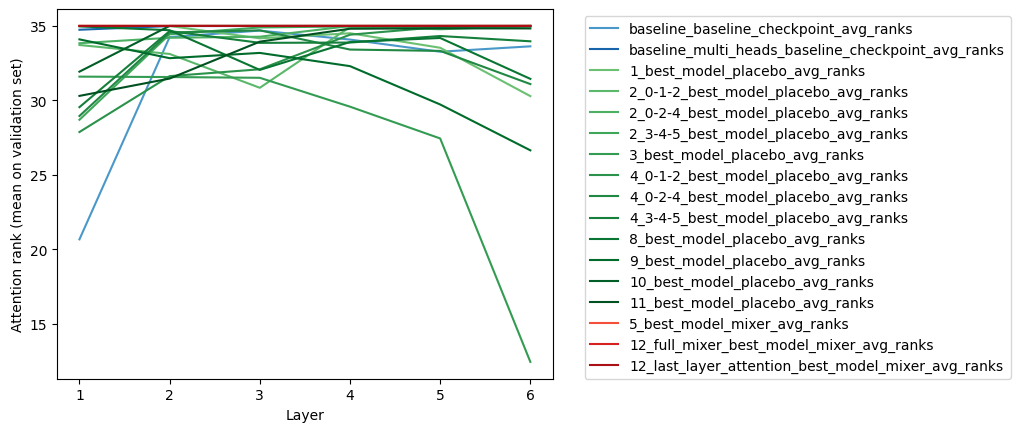

In [ ]:
for i, x in enumerate(baselines_path):
    plt.plot(range(1,7), np.load(x), color=color_map_baseline[len(baselines_path)+i])
for i, x in enumerate(placebos_path):
    plt.plot(range(1,7), np.load(x), color=color_map_placebo[len(placebos_path)+i])
for i, x in enumerate(mixers_path):
    plt.plot(range(1,7), np.load(x), color=color_map_mixer[len(mixers_path)+i])
legends = [x.replace(prefix_path_models, "").replace("/", "_").replace(".npy", "") for x in [*baselines_path, *placebos_path, *mixers_path]]
plt.legend(legends, bbox_to_anchor=(1.05, 1.0), loc="upper left")
plt.xlabel("Layer")
plt.ylabel("Attention rank (mean on validation set)")
plt.show()